In [9]:
%pip install statsmodels
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Load the data
df = pd.read_csv('Datasets/data_NO2.csv', sep=';', parse_dates=['datetime_utc'])
df.set_index('datetime_utc', inplace=True)
df = df.resample('D').mean()

# Display basic information about the dataset
print(df.info())
print("\nFirst few rows:")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 988 entries, 2015-12-31 00:00:00+00:00 to 2018-09-13 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   volume_demand      988 non-null    float64
 1   volume_production  988 non-null    float64
 2   spot_price         988 non-null    float64
dtypes: float64(3)
memory usage: 30.9 KB
None

First few rows:
                           volume_demand  volume_production  spot_price
datetime_utc                                                           
2015-12-31 00:00:00+00:00    4043.000000        7818.000000   16.390000
2016-01-01 00:00:00+00:00    4330.958333        8268.416667   16.622500
2016-01-02 00:00:00+00:00    4645.625000        7388.500000   15.377500
2016-01-03 00:00:00+00:00    4903.833333        7867.000000   16.045000
2016-01-04 00:00:00+00:00    5365.958333        8981.916667   18.644167


In [11]:
# Create time-based features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Create lag features for spot_price
for lag in [1, 2, 3, 7, 14, 30]:
    df[f'spot_price_lag_{lag}'] = df['spot_price'].shift(lag)

# Create rolling mean features
for window in [7, 14, 30]:
    df[f'spot_price_rolling_mean_{window}'] = df['spot_price'].rolling(window=window).mean()

# Create rolling standard deviation features
for window in [7, 14, 30]:
    df[f'spot_price_rolling_std_{window}'] = df['spot_price'].rolling(window=window).std()

print(df.head())

                           volume_demand  volume_production  spot_price  \
datetime_utc                                                              
2015-12-31 00:00:00+00:00    4043.000000        7818.000000   16.390000   
2016-01-01 00:00:00+00:00    4330.958333        8268.416667   16.622500   
2016-01-02 00:00:00+00:00    4645.625000        7388.500000   15.377500   
2016-01-03 00:00:00+00:00    4903.833333        7867.000000   16.045000   
2016-01-04 00:00:00+00:00    5365.958333        8981.916667   18.644167   

                           day_of_week  month  quarter  year  is_weekend  \
datetime_utc                                                               
2015-12-31 00:00:00+00:00            3     12        4  2015           0   
2016-01-01 00:00:00+00:00            4      1        1  2016           0   
2016-01-02 00:00:00+00:00            5      1        1  2016           1   
2016-01-03 00:00:00+00:00            6      1        1  2016           1   
2016-01-04 00:00:0

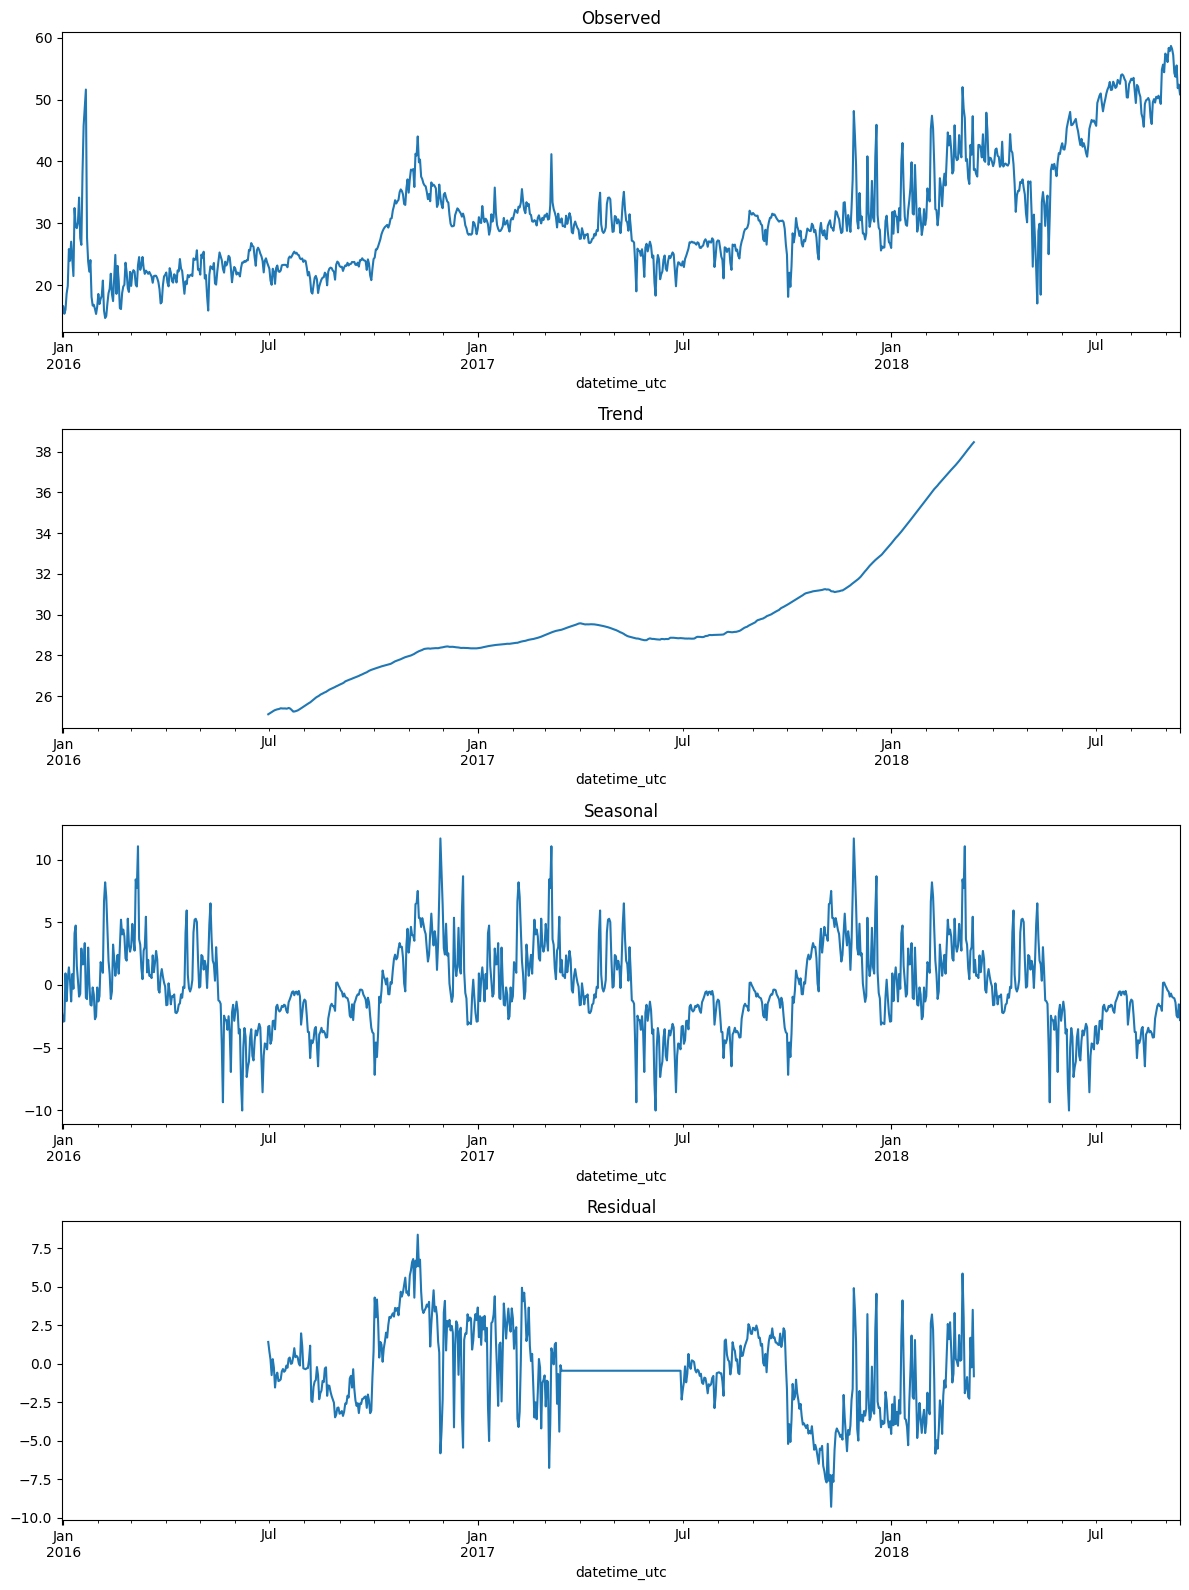

In [12]:
# Perform seasonal decomposition
result = seasonal_decompose(df['spot_price'], model='additive', period=365)

df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
result.observed.plot(ax=ax1)
ax1.set_title('Observed')
result.trend.plot(ax=ax2)
ax2.set_title('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

In [13]:
# Create target variables for 7-day ahead forecasting
for i in range(1, 8):
    df[f'spot_price_target_t+{i}'] = df['spot_price'].shift(-i)

print(df.head())

                           volume_demand  volume_production  spot_price  \
datetime_utc                                                              
2015-12-31 00:00:00+00:00    4043.000000        7818.000000   16.390000   
2016-01-01 00:00:00+00:00    4330.958333        8268.416667   16.622500   
2016-01-02 00:00:00+00:00    4645.625000        7388.500000   15.377500   
2016-01-03 00:00:00+00:00    4903.833333        7867.000000   16.045000   
2016-01-04 00:00:00+00:00    5365.958333        8981.916667   18.644167   

                           day_of_week  month  quarter  year  is_weekend  \
datetime_utc                                                               
2015-12-31 00:00:00+00:00            3     12        4  2015           0   
2016-01-01 00:00:00+00:00            4      1        1  2016           0   
2016-01-02 00:00:00+00:00            5      1        1  2016           1   
2016-01-03 00:00:00+00:00            6      1        1  2016           1   
2016-01-04 00:00:0

In [14]:
# Remove rows with NaN values
df_cleaned = df.dropna()

# Select features and target variables
features = df_cleaned[['spot_price', 'day_of_week', 'month', 'quarter', 'year', 'is_weekend',
                       'spot_price_lag_1', 'spot_price_lag_2', 'spot_price_lag_3', 'spot_price_lag_7',
                       'spot_price_lag_14', 'spot_price_lag_30',
                       'spot_price_rolling_mean_7', 'spot_price_rolling_mean_14', 'spot_price_rolling_mean_30',
                       'spot_price_rolling_std_7', 'spot_price_rolling_std_14', 'spot_price_rolling_std_30',
                       'trend', 'seasonal', 'residual']]

targets = df_cleaned[[f'spot_price_target_t+{i}' for i in range(1, 8)]]

# One-hot encode categorical variables
features = pd.get_dummies(features, columns=['day_of_week', 'month', 'quarter', 'year'])

# Scale numerical features
scaler = MinMaxScaler()
numerical_columns = ['spot_price', 'spot_price_lag_1', 'spot_price_lag_2', 'spot_price_lag_3', 'spot_price_lag_7',
                     'spot_price_lag_14', 'spot_price_lag_30',
                     'spot_price_rolling_mean_7', 'spot_price_rolling_mean_14', 'spot_price_rolling_mean_30',
                     'spot_price_rolling_std_7', 'spot_price_rolling_std_14', 'spot_price_rolling_std_30',
                     'trend', 'seasonal', 'residual']

features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

print("Features shape:", features.shape)
print("Targets shape:", targets.shape)

Features shape: (624, 43)
Targets shape: (624, 7)


In [15]:
# Save the prepared datasets
features.to_csv('prepared_data/prepared_features.csv')
targets.to_csv('prepared_data/prepared_targets.csv')

print("Datasets saved successfully.")

Datasets saved successfully.
